In [2]:
import numpy as np

from pathlib import Path
from matplotlib import pyplot as plt

from flowrec.utils.simulation import read_data_kolsol
from flowrec.data import get_whitenoise_std

In [3]:
data = read_data_kolsol('./local_data/kolmogorov/dim2_re34_k32_f4_dt01_grid128.h5')
import h5py
# with h5py.File('./local_data/kolmogorov/dim2_re34_k32_f4_dt01_grid128_long.h5') as hf:
#     data = hf.get('state')[:,:50,:50,:]
# data = np.array(data)
datalength = data.shape[0]

In [4]:
point = (43,12)
u = data[:,point[0],point[1],0]
v = data[:,point[0],point[1],1]
p = data[:,point[0],point[1],2]

In [5]:
rng = np.random.default_rng(23910)
un = u + rng.normal(loc=0.0,scale=get_whitenoise_std(20,np.std(u)),size=(datalength))
vn = v + rng.normal(loc=0.0,scale=get_whitenoise_std(20,np.std(v)),size=(datalength))
pn = p + rng.normal(loc=0.0,scale=get_whitenoise_std(20,np.std(p)),size=(datalength))
un_all = data[...,0] + rng.normal(loc=0.0,scale=get_whitenoise_std(20,np.std(data[...,0])),size=data.shape[:-1])

In [6]:
# taking only fluctuating velocity
u = u - np.mean(u)
un = un - np.mean(un)
v = v - np.mean(v)
vn = vn - np.mean(vn)
p = p - np.mean(p)
pn = pn - np.mean(pn)

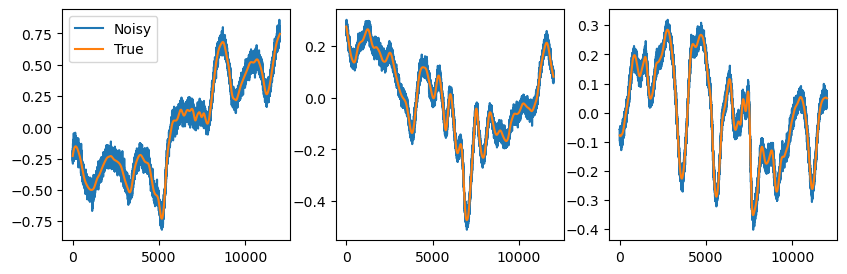

In [7]:
fig,axes = plt.subplots(1,3,figsize=(10,3))

axes[0].plot(un,label='Noisy')
axes[0].plot(u,label='True')
axes[0].legend()
axes[1].plot(vn)
axes[1].plot(v)
axes[2].plot(pn)
axes[2].plot(p)
plt.show()

Integral time scale

In [8]:
def autocorrelation(x):
    a = x - np.mean(x)
    autocorr = np.correlate(a,a,'full')[-len(a):]
    autocorr = autocorr / np.sum(a**2)
    return autocorr

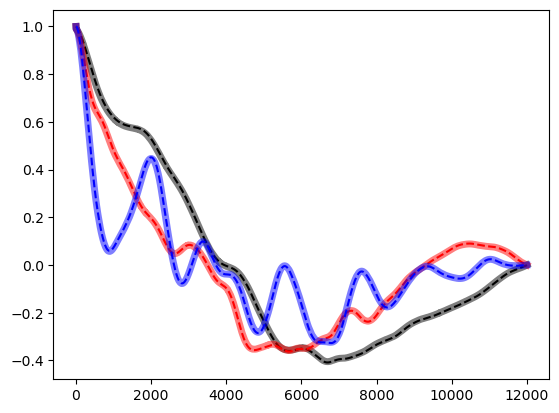

In [9]:
un_corr = autocorrelation(un)
u_corr = autocorrelation(u)
vn_corr = autocorrelation(vn)
v_corr = autocorrelation(v)
pn_corr = autocorrelation(pn)
p_corr = autocorrelation(p)

plt.figure()
plt.plot(un_corr,c='k',linewidth='5',alpha=0.5)
plt.plot(u_corr,c='k',linestyle='--')
plt.plot(vn_corr,c='r',linewidth='5',alpha=0.5)
plt.plot(v_corr,c='r',linestyle='--')
plt.plot(pn_corr,c='b',linewidth='5',alpha=0.5)
plt.plot(p_corr,c='b',linestyle='--')
plt.show()

In [10]:
dt = 0.01
t = np.linspace(0,len(u)-1,len(u))*0.01

In [11]:
t1 = np.trapz(u_corr,dx=dt)
print(t1)
print(t1/dt)
print(10*t1/dt)

4.801866211323613e-07
4.801866211323613e-05
0.0004801866211323613


In [12]:
idxx = np.random.randint(0,50,20)
idxy = np.random.randint(0,50,20)

In [13]:
tscale_list = []
for ii in range(3):
    for ix,iy in zip(idxx,idxy):
        c = autocorrelation(data[:,ix,iy,ii])
        tscale_list.append(
            np.trapz(c,dx=dt)
        )
        # if i % 128 == 0:
        #     print(f'row {int(i/128)}')
tscale = np.mean(tscale_list)

In [14]:
print(tscale,tscale/dt) # integral time scale, integral time scale in snapshots

1.471156370151198e-07 1.4711563701511979e-05


# 1: compute the periodogram of the observations
The window length must be one order of magnitude larger than the integral time scale.

The result should have length that is 1. even and 2. equal to or longer than the original sequence.

In [15]:
fs = 1/dt
print(fs)
ls = len(un)
print('length of signal: ',ls)
if ls%2 != 0:
    nfft = ls+1
else:
    nfft = ls
window = np.hanning(ls)
fftfreq = np.fft.fftfreq(nfft,dt)
df = fs/datalength
idx_positive = np.s_[:int(nfft/2)]

100.0
length of signal:  12000


In [16]:
power_utrue = np.abs(np.fft.fft(u*window,nfft))**2
power_un = np.abs(np.fft.fft(un*window,nfft))**2
power_vn = np.abs(np.fft.fft(vn*window,nfft))**2
power_pn = np.abs(np.fft.fft(pn*window,nfft))**2

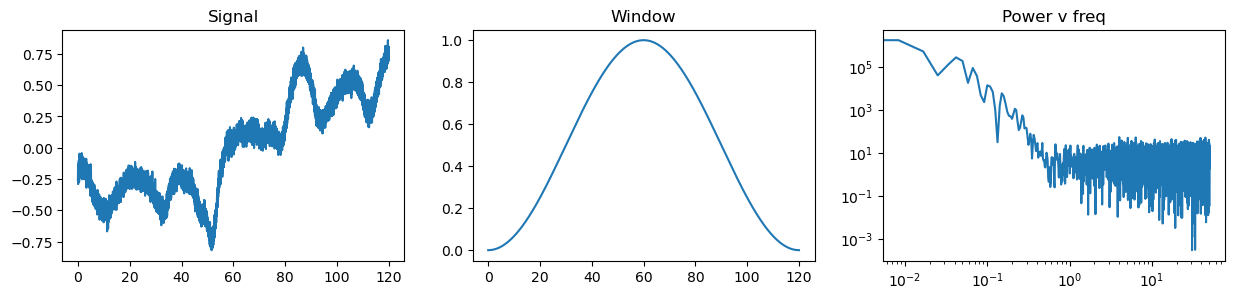

In [17]:
# Velocity u only
fig,axes = plt.subplots(1,3,figsize=(15,3))
axes[0].plot(t,un)
axes[0].set_title('Signal')
axes[1].plot(t,window)
axes[1].set_title('Window')
axes[2].plot(fftfreq[idx_positive],power_un[idx_positive],'-')
axes[2].set_title('Power v freq')
axes[2].set_yscale('log')
axes[2].set_xscale('log')
plt.show()

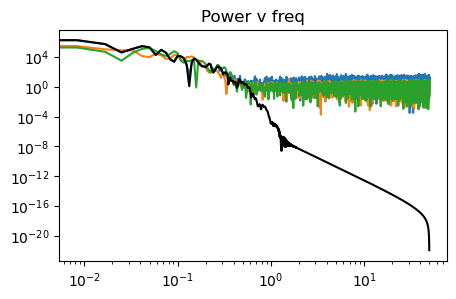

In [18]:
# u, v, p
fig,ax = plt.subplots(1,1,figsize=(5,3))
for i,a in enumerate([power_un,power_vn,power_pn]):
    ax.plot(fftfreq[idx_positive],a[idx_positive],'-')
ax.plot(fftfreq[idx_positive],power_utrue[idx_positive],'k')
ax.set_title('Power v freq')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

# 2: Estimate noise power and cutoff frequency for low-passs filter
The noise floor upper limit is $Fs/2 - \Delta f$.

<!-- The transfer function is $H_i(f) = 1 - \phi_{\epsilon_i} / \hat{\phi}_{ii}$, where $\hat{\phi_{ii}}$ is the spectrum of the i-th observed. -->

In [19]:
# Find the noise range
f_lower = 0.4*fs
f_upper = 0.5*fs - np.abs(fftfreq[-1]-fftfreq[-2])
idx_lower = (np.abs(fftfreq - f_lower)).argmin()
idx_upper = (np.abs(fftfreq - f_upper)).argmin()
print(idx_lower,idx_upper)

4800 5999


In [20]:
un[10]

-0.29084128079505955

In [21]:
len(power_un.shape)

1

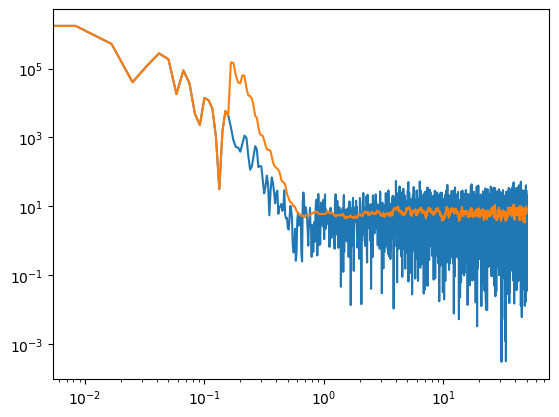

In [22]:
def movemean(signal,window,i):
    l = len(signal)
    w2 = int(window/2)
    # if w2 > i:
    #     raise ValueError('Not enough points in the window.')
    smooth_signal = np.zeros_like(signal)
    if i>0:
        smooth_signal[:i] = signal[:i]
    if w2>i:
        start_from = w2
        for j in range(i,w2):
            smooth_signal[j] = np.mean(signal[j-i:j+1])
            # smooth_signal[j] = np.mean(signal[j:j+1])
    else:
        start_from = i
    for j in range(start_from,l):
        smooth_signal[j] = np.mean(signal[j-w2:j+w2])
    return smooth_signal

smooth_power_un = movemean(power_un,51,20)
plt.figure()
plt.plot(fftfreq[idx_positive],power_un[idx_positive])
plt.plot(fftfreq[idx_positive],smooth_power_un[idx_positive])
plt.yscale('log')
plt.xscale('log')
plt.show()


0.6


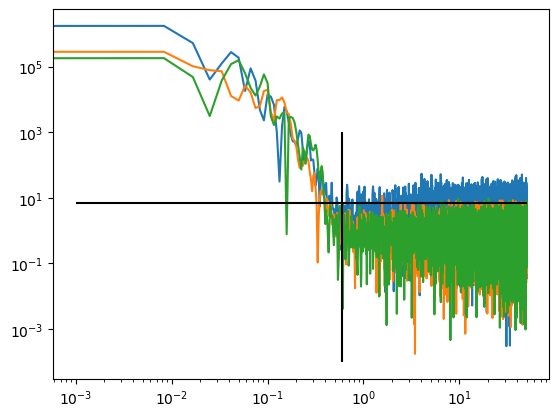

In [23]:
plt.figure()
plt.plot(fftfreq[idx_positive],power_un[idx_positive])
plt.plot(fftfreq[idx_positive],power_vn[idx_positive])
plt.plot(fftfreq[idx_positive],power_pn[idx_positive])
plt.yscale('log')
plt.xscale('log')
noise_estimate_u = np.mean(smooth_power_un[idx_lower:idx_upper])
plt.hlines(noise_estimate_u,0.001,50,'k')
idx_crossover = np.argmax(smooth_power_un<noise_estimate_u)
cutoff_freq = idx_crossover*df
plt.vlines(cutoff_freq,0.0001,1000,'k')
print(cutoff_freq)
plt.show()

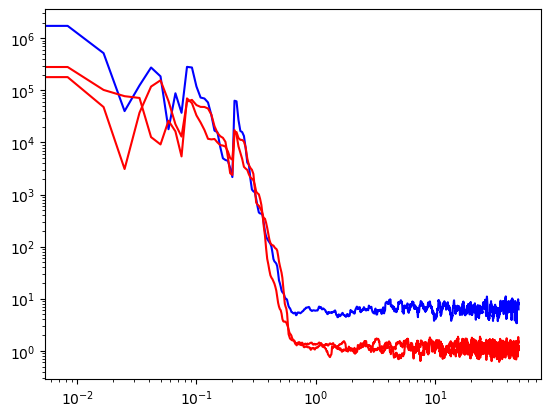

In [24]:
smooth_power_un = movemean(power_un,51,10)
smooth_power_vn = movemean(power_vn,51,10)
smooth_power_pn = movemean(power_pn,51,10)

plt.figure()
plt.plot(fftfreq[idx_positive],smooth_power_un[idx_positive],'b')
plt.plot(fftfreq[idx_positive],smooth_power_vn[idx_positive],'r')
plt.plot(fftfreq[idx_positive],smooth_power_pn[idx_positive],'r')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [25]:
noise_estimate_u = np.mean(smooth_power_un[idx_lower:idx_upper])
noise_estimate_v = np.mean(smooth_power_vn[idx_lower:idx_upper])
noise_estimate_p = np.mean(smooth_power_pn[idx_lower:idx_upper])

slack_f = 0.1*fs/2
cutoff_u = np.argmax(smooth_power_un<noise_estimate_u)*df+slack_f 
cutoff_v = np.argmax(smooth_power_vn<noise_estimate_v)*df+slack_f
cutoff_p = np.argmax(smooth_power_pn<noise_estimate_p)*df+slack_f 

# 3. Low pass filter 

First find cutoff using estimated noise from signal (moving average)

In [26]:
from scipy.signal import filtfilt, butter

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / fs/2
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [27]:
filtered_u_lowpass = butter_lowpass_filter(un,cutoff_u,fs,2)
filtered_v_lowpass = butter_lowpass_filter(vn,cutoff_v,fs,2)
filtered_p_lowpass = butter_lowpass_filter(pn,cutoff_p,fs,2)

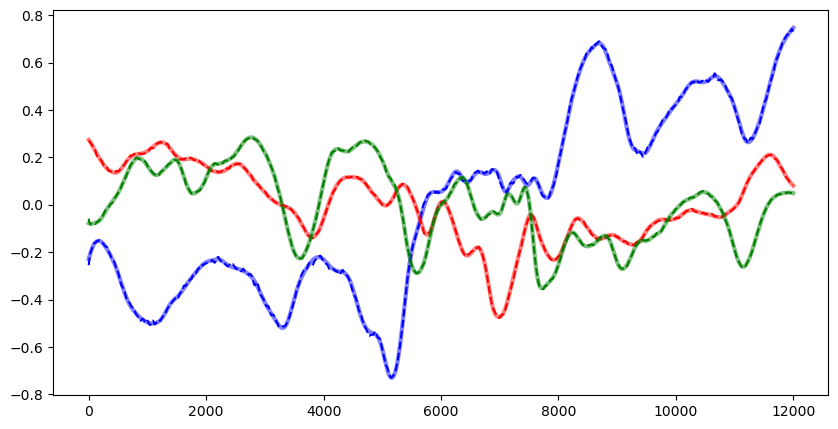

In [28]:
plt.figure(figsize=(10,5))
plt.plot(u,linewidth=3,label=True,c='b',alpha=0.5)
plt.plot(filtered_u_lowpass,'b--')
plt.plot(v,linewidth=3,label=True,c='r',alpha=0.5)
plt.plot(filtered_v_lowpass,'r--')
plt.plot(p,linewidth=3,label=True,c='g',alpha=0.5)
plt.plot(filtered_p_lowpass,'g--')
plt.show()

# Conclusion


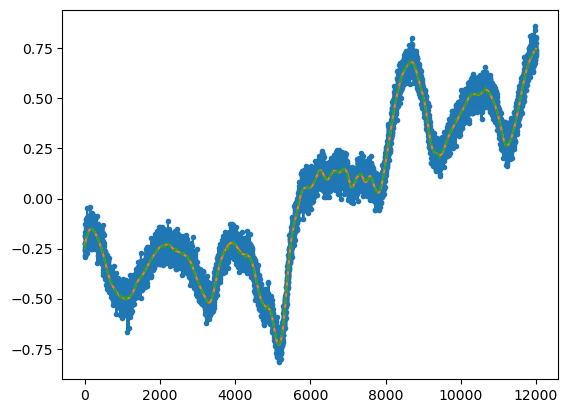

In [31]:
from flowrec import signal as fsig

test_noise, test_power = fsig.estimate_noise_floor(un,fs,window_size=50,start_idx=10)
test_cutoff = fsig.estimate_noise_cutoff_frequency(test_power,test_noise,fs/len(un),0.1*fs/2)
test_filtered = fsig.butter_lowpass_filter(un,test_cutoff,fs)
plt.figure()
plt.plot(un,'.-')
plt.plot(u)
plt.plot(test_filtered,'--')
plt.show()